# Emotion Recognition Using Wav2Vec 2.0

In [1]:
%%capture
# Install necessary packages for audio processing and emotion recognition
!pip install jiwer torchaudio librosa

# Install Hugging Face datasets and transformers for model usage
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git

# Monitor the training process
# !pip install wandb

In [2]:
# Setting environment variables for the notebook
# LC_ALL and LANG are set to C.UTF-8 to ensure consistent character encoding
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8

# Setting cache directories for transformers and datasets
%env TRANSFORMERS_CACHE=.
%env HF_DATASETS_CACHE=.

# Setting CUDA_LAUNCH_BLOCKING to 1 to enable synchronous CUDA kernel launches
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=.
env: HF_DATASETS_CACHE=.
env: CUDA_LAUNCH_BLOCKING=1


## Prepare Data

CREMA-D (Crowd Sourced Emotional Multimodal Actors Dataset)
License: Open Database License, https://opendatacommons.org/licenses/odbl/1-0/

- Number of Dataset: 7442
- 48 male and 43 female actors between the ages of 20 and 74.
- A variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified).
- Emotion 6 Classes: Anger, Disgust, Fear, Happy, Neutral, Sad
- In addition, it contains Gender, Age and Emotion Level features.

In [13]:
# Importing necessary libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing Path for file path manipulation and tqdm for progress bars
from pathlib import Path
from tqdm import tqdm

# Importing torchaudio for audio processing and sklearn for model selection
import torchaudio
from sklearn.model_selection import train_test_split
import librosa
import IPython.display as ipd
from IPython.display import Image
from IPython.display import Audio
from datasets import load_dataset

# Importing os and sys for system operations and system-specific parameters
import os
import sys
from rich import print

# Defining the path and specifying the python dictionary mapping the emotoin to the integer value
root_data_path = "Dataset/RAVDESS/audio_speech_actors_01-24"
SAMPLE_RATE = 48000

### Preparing the dataset

In [3]:
%%time
# Creating a dataframe structure
data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
emotion_label = {0:'surprise', 1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust'} 

for dirpath, sub_dirnames, filenames in os.walk(root_data_path):

    # Going over all the files from the given directory
    for filename in filenames:

        # Creating the path for accessing the file
        file_path = os.path.join(dirpath,filename)

        # Getting list of file identifies
        file_identifies = filename.split('.')[0].split('-')

        # Retriveing the information about the gender of the speaker (0:Female and 1:Male)
        gender_info = int(file_identifies[6])%2
        if gender_info == 0:
            gender = 'female'
        else:
            gender='male'

        # Retrieving the emotional intensity information
        emotion_intensity = (int(file_identifies[3]))
        if emotion_intensity == 1:
            emotion_intensity = 'normal'
        else:
            emotion_intensity = 'strong'

        # Retriving the type of emotion
        emotion = (int(file_identifies[2]))
        if emotion == 8: # change surprise from 8 to 0
            emotion = 0

        # Appending the current file information
        data = pd.concat([data, pd.DataFrame([{"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path}])], ignore_index=True)

CPU times: total: 281 ms
Wall time: 318 ms


In [4]:
# Checking random 10 rows of the dataframe
data

,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
2,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
3,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
4,2,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
...,...,...,...,...
1435,0,normal,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1436,0,strong,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1437,0,strong,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1438,0,strong,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...


In [5]:
count = 0
for file_path in data['Path'].values:
    
    # Check if the file is broken or non-existent
    try:
        # Load the file with torchaudio
        s = torchaudio.load(file_path)
        count = count + 1
    except Exception as e:
        # Print the error if the file is broken or non-existent
        print(f"Error loading file {file_path}: {e}")
        pass

print("Correct file count : ",count)
print("Total file cound : ",len(data))


Correct file count :  1440

Total file cound :  1440

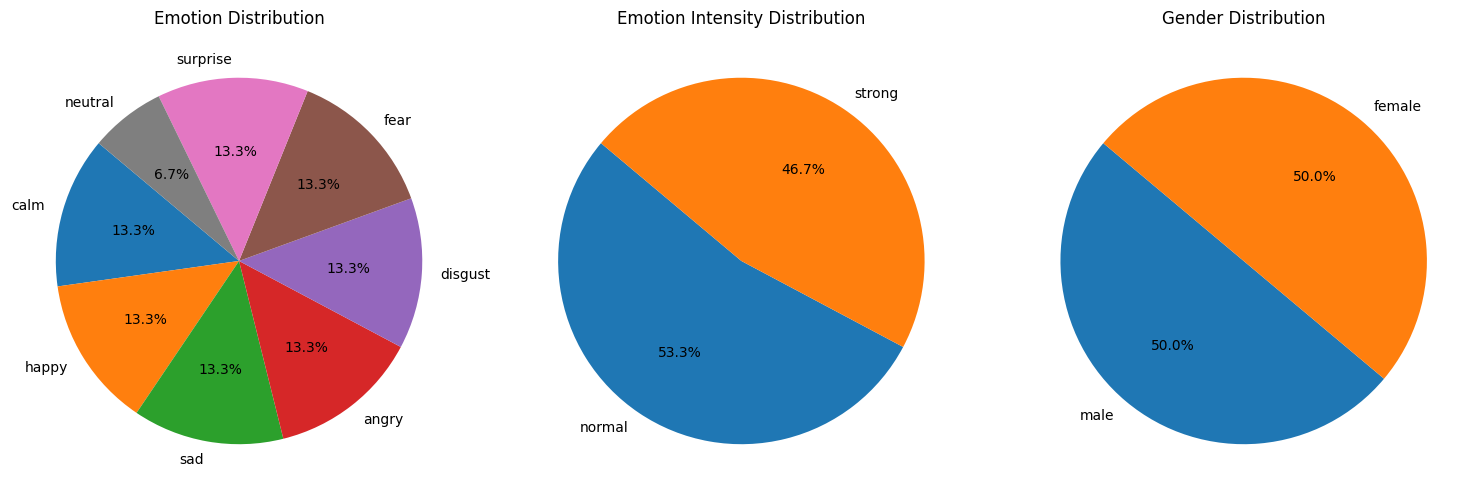

In [6]:
# Create pie charts for Emotion, Emotion intensity, and Gender
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Pie chart for Emotion
emotion_counts = data['Emotion'].value_counts()
labels = [emotion_label[i] for i in emotion_counts.index]
axs[0].pie(emotion_counts, labels=labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Emotion Distribution')

# Pie chart for Emotion intensity
emotion_intensity_counts = data['Emotion intensity'].value_counts()
axs[1].pie(emotion_intensity_counts, labels=emotion_intensity_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Emotion Intensity Distribution')

# Pie chart for Gender
gender_counts = data['Gender'].value_counts()
axs[2].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Gender Distribution')

plt.tight_layout()
plt.show()

Right now we have actually prepared the dataset from the files along with other meta data associated with it, but one more thing which we need to do is to check whether all the files are correct or not.

In [7]:
print(f"File count Before: {len(data)}")

# Add a 'status' column to check if the file path exists
data["status"] = data["Path"].apply(lambda path: True if os.path.exists(path) else None)

# Drop rows where 'status' is None, indicating non-existent paths
data = data.dropna(subset=["Path"])

# Remove the 'status' column as it's no longer needed
data = data.drop("status", axis=1) 

# Print the file count after filtering out non-existent paths
print(f"File counter after: {len(data)}")

File count Before: 1440

File counter after: 1440

Sampling Rate (SAMPLE_RATE): The sampling rate is the number of samples of audio carried per second. For example, if the sampling rate is 22050 Hz, it means that 22,050 samples are taken every second.
Duration of Interest: In this case, the code is interested in processing audio data for a fixed duration of 3 seconds. This is a common practice in audio processing, especially in machine learning applications, where having a consistent input size is crucial.

3. Calculating the Array Length: By multiplying the sampling rate by 3, you get the total number of samples that correspond to 3 seconds of audio. For example:

- If SAMPLE_RATE is 22050 Hz, then SAMPLE_RATE * 3 equals 66,150. This means that the array signal will have 66,150 elements, which can hold the audio data for 3 seconds.
- Zero-Initialization: The array is initialized with zeros to ensure that if the loaded audio data is shorter than 3 seconds, the remaining part of the array will be filled with zeros (representing silence). This is important for maintaining a consistent shape for all audio signals, which is necessary for further processing, such as feature extraction or feeding into a machine learning model.

Summary
In summary, multiplying the sampling rate by 3 allows the code to create a fixed-size array that can accommodate 3 seconds of audio data, ensuring consistency in the input shape for subsequent processing steps. This approach is particularly useful in machine learning tasks where uniform input sizes are required.

In [8]:
%%time
mel_spectrograms = []  # Initialize an empty list to store mel spectrograms
signals = []           # Initialize an empty list to store audio signals

# Loop through each file path in the 'data.Path' list
for i, file_path in enumerate(data.Path):
    # Load the audio file using librosa
    # - 'duration=3' means we only load the first 3 seconds of the audio
    # - 'offset=0.5' means we start loading the audio from 0.5 seconds into the file
    # - 'sr=SAMPLE_RATE' sets the sample rate to a predefined constant SAMPLE_RATE
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    
    # Create a zero-initialized numpy array of length SAMPLE_RATE * 3 (3 seconds)
    signal = np.zeros((int(SAMPLE_RATE * 3),))
    
    # Fill the beginning of the signal array with the loaded audio data
    signal[:len(audio)] = audio
    
    # Append the processed signal to the signals list
    signals.append(signal)

# Stack the list of signals into a 2D numpy array
signals = np.stack(signals, axis=0)

CPU times: total: 2.06 s
Wall time: 3.15 s


Let's display some random sample of the dataset and run it a couple of times to get a feeling for the audio and the emotional label.

In [10]:
data

,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
2,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
3,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
4,2,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
...,...,...,...,...
1435,0,normal,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1436,0,strong,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1437,0,strong,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1438,0,strong,female,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...


In [11]:
emotion_label[5]

'angry'

In [15]:
# Selecting the random audio file
sample = data.iloc[760]
path = sample["Path"]
label = emotion_label[sample["Emotion"]]

print(f"ID Location: {idx}")
print(f"Label: {label}")

# Load the audio file using torchaudio
speech, sr = torchaudio.load(path)

# Convert the loaded audio to numpy format and squeeze the dimensions
speech = speech[0].numpy().squeeze()

# Resample the audio to a standard rate of 16,000 Hz using librosa
speech = librosa.resample(speech, orig_sr=sr, target_sr=16000)

# Display the audio using IPython.display.Audio with autoplay enabled and the correct rate
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 760

Label: fear

In [17]:
# Selecting the random audio file
sample = data.iloc[760]
path = sample["Path"]
label = emotion_label[sample["Emotion"]]

print(f"ID Location: {idx}")
print(f"Label: {label}")

# Load the audio file using torchaudio
speech, sr = torchaudio.load(path)

# Convert the loaded audio to numpy format and squeeze the dimensions
speech = speech[0].numpy().squeeze()

# Resample the audio to a standard rate of 16,000 Hz using librosa
speech = librosa.resample(speech, orig_sr=sr, target_sr=48000)

# Display the audio using IPython.display.Audio with autoplay enabled and the correct rate
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=48000)

ID Location: 760

Label: fear

For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [28]:
data.head(5)

,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
1,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
2,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
3,1,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...
4,2,normal,male,Dataset/RAVDESS/audio_speech_actors_01-24\Acto...


In [29]:
def split_data(signals, data, EMOTIONS):
    """
    Splits the data into training, validation, and testing sets based on emotions.
    
    Parameters:
    - signals (numpy array): The array of signals to be split.
    - data (pandas DataFrame): The DataFrame containing the data.
    - EMOTIONS (list): A list of emotions to split the data by.
    
    Returns:
    - X_train, X_val, X_test (numpy arrays): The split signal data for training, validation, and testing.
    - Y_train, Y_val, Y_test (numpy arrays): The corresponding labels for training, validation, and testing.
    - train_ind, val_ind, test_ind (numpy arrays): The indices of the split data.
    """
    train_ind,test_ind,val_ind = [],[],[]
    X_train,X_val,X_test = [],[],[]
    Y_train,Y_val,Y_test = [],[],[]
    
    # Iterate through each emotion to split the data
    for emotion in range(len(emotion_label)):
        emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
        emotion_ind = np.random.permutation(emotion_ind)  # Shuffle the indices for each emotion
        m = len(emotion_ind)
        
        # Splitting indices for training, validation, and testing
        ind_train = emotion_ind[:int(0.8*m)]
        ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
        ind_test = emotion_ind[int(0.9*m):]
        
        # Appending the split data and labels
        X_train.append(signals[ind_train,:])
        Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
        X_val.append(signals[ind_val,:])
        Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
        X_test.append(signals[ind_test,:])
        Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
        
        # Appending the indices
        train_ind.append(ind_train)
        test_ind.append(ind_test)
        val_ind.append(ind_val)
    
    # Concatenating the split data and labels
    X_train = np.concatenate(X_train,0)
    X_val = np.concatenate(X_val,0)
    X_test = np.concatenate(X_test,0)
    Y_train = np.concatenate(Y_train,0)
    Y_val = np.concatenate(Y_val,0)
    Y_test = np.concatenate(Y_test,0)
    train_ind = np.concatenate(train_ind,0)
    val_ind = np.concatenate(val_ind,0)
    test_ind = np.concatenate(test_ind,0)
    
    # Printing the shapes of the split data and labels
    print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
    print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
    print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
    
    # Checking if all indices are unique
    unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
    print("Number of unique indexes is {}, out of {}".format(sum(count==1), signals.shape[0]))
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test, train_ind, val_ind, test_ind

# Example usage
X_train, X_val, X_test, Y_train, Y_val, Y_test, train_ind, val_ind, test_ind = split_data(signals, data, emotion_label)

X_train:(1147, 144000), Y_train:(1147,)

X_val:(143, 144000), Y_val:(143,)

X_test:(150, 144000), Y_test:(150,)

Number of unique indexes is 1440, out of 1440

### Augment signals by adding AWGN

In [27]:
import numpy as np
import sounddevice as sd

# Parameters
duration = 3  # seconds
sampling_rate = 44100  # samples per second (CD quality audio)
frequency = 440  # frequency of the sine wave (A4 note)

# Generate a sine wave
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
sine_wave = 0.5 * np.sin(2 * np.pi * frequency * t)  # amplitude 0.5

# Function to add AWGN
def add_awgn(signal, snr_db):
    """Add AWGN to a signal with a given SNR in dB."""
    signal_power = np.mean(signal**2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

# Add AWGN with an SNR of 10 dB
noisy_signal = add_awgn(sine_wave, snr_db=1)

# Play the noisy signal
sd.play(noisy_signal, samplerate=sampling_rate)
sd.wait()  # Wait for the sound to finish playing


In [30]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    """
    This function adds Additive White Gaussian Noise (AWGN) to a given signal.
    
    Parameters:
    - signal: The input signal to which AWGN will be added.
    - num_bits: The number of bits used to represent the signal. Default is 16.
    - augmented_num: The number of augmented signals to generate. Default is 2.
    - snr_low: The lower bound of the Signal-to-Noise Ratio (SNR) in dB. Default is 15.
    - snr_high: The upper bound of the SNR in dB. Default is 30.
    
    Returns:
    - Noisy signal(s) with AWGN added.
    """
    # Get the length of the signal
    signal_len = len(signal)
    
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    
    # Generate noisy signal
    return signal + K.T * noise

In [33]:
%%time
# Initialize empty lists to store augmented signals and labels
aug_signals = []
aug_labels = []

# Loop over each signal in the training set
for i in range(X_train.shape[0]):
    # Get the current signal
    signal = X_train[i,:]
    
    # Add AWGN to the signal
    augmented_signals = addAWGN(signal)
    
    # Loop over each augmented signal
    for j in range(augmented_signals.shape[0]):
        # Add the label of the original signal to the list
        aug_labels.append(data.loc[i,"Emotion"])
        
        # Add the augmented signal to the list
        aug_signals.append(augmented_signals[j,:])
        
        # Add a new row to the data with the same information as the original row
        # Corrected the DataFrame append method
        data = pd.concat([data, data.iloc[[i]]], ignore_index=True)
        
# Stack the augmented signals into a single array
aug_signals = np.stack(aug_signals,axis=0)

# Concatenate the augmented signals with the original training set
X_train = np.concatenate([X_train,aug_signals],axis=0)

# Stack the augmented labels into a single array
aug_labels = np.stack(aug_labels,axis=0)

# Concatenate the augmented labels with the original training labels
Y_train = np.concatenate([Y_train,aug_labels])

# Print the final shape of the training set and labels
print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')

Processed 682/1147 files

X_train:(3441, 144000), Y_train:(3441,)

CPU times: total: 13.9 s
Wall time: 31.1 s


### Calculating mel spectrograms

In [ ]:
def getMELspectrogram(audio, sample_rate):
    """
    This function calculates the Mel spectrogram of an audio signal.
    
    Parameters:
    - audio (numpy array): The audio signal.
    - sample_rate (int): The sample rate of the audio signal.
    
    Returns:
    - mel_spec_db (numpy array): The Mel spectrogram of the audio signal in decibels.
    """
    # Calculate the Mel spectrogram of the audio signal
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,  # Window size for the FFT
                                              win_length=512,  # Window size for the analysis window
                                              window='hamming',  # Window function
                                              hop_length=256,  # Number of samples between successive frames
                                              n_mels=128,  # Number of Mel bands to generate
                                              fmax=sample_rate/2  # Maximum frequency
                                             )
    # Convert the Mel spectrogram to decibels
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Test the function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5, sr=SAMPLE_RATE)

# Pad the audio signal to the desired length
signal = np.zeros((int(SAMPLE_RATE*3),))
signal[:len(audio)] = audio

# Calculate the Mel spectrogram
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)

# Display the Mel spectrogram
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ', mel_spectrogram.shape)

In [61]:
save_path = "Final_data"

# Separating the data into trainign and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["label"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)

(5953, 2)

(1489, 2)

## Prepare Data for Training

In [69]:
# Define the paths to the train and validation CSV files
data_files = {
    "train": "Final_data/train.csv",
    "validation": "Final_data/test.csv",
}

# Load the datasets from the CSV files using the specified delimiter
dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

# Extract the train and validation datasets
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

# Print the train and validation datasets for verification
print(train_dataset)
print(eval_dataset)

Generating train split: 5953 examples [00:00, 164625.12 examples/s]
Generating validation split: 1489 examples [00:00, 121113.11 examples/s]


Dataset({
    features: ['file_path', 'label'],
    num_rows: 5953
})

Dataset({
    features: ['file_path', 'label'],
    num_rows: 1489
})